In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
pd.set_option('mode.chained_assignment', None)

In [2]:
#生成小组赛结果
group_matchs = pd.read_csv('group_matchs.csv') #读取小组赛比分
group_matchs.loc[group_matchs['HomeTeamGoals']>group_matchs['AwayTeamGoals'], 'results']= '胜' #定义三种结果
group_matchs.loc[group_matchs['HomeTeamGoals']==group_matchs['AwayTeamGoals'], 'results']= '平'
group_matchs.loc[group_matchs['HomeTeamGoals']<group_matchs['AwayTeamGoals'], 'results']= '负'
group_matchs.head()

,HomeTeamName,AwayTeamName,HomeTeamGoals,AwayTeamGoals,results
0,土耳其,意大利,0,3,负
1,威尔士,瑞士,1,1,平
2,丹麦,芬兰,0,1,负
3,比利时,俄罗斯,3,0,胜
4,英格兰,克罗地亚,1,0,胜


In [3]:
#生成小组赛双方的数据对比
team_status=pd.read_csv('team_status.csv',index_col=0)#读取小组赛的比赛数据
home_team_df=team_status.reindex(group_matchs['HomeTeamName'])#重新设置索引以便拼接
away_team_df=team_status.reindex(group_matchs['AwayTeamName'])
home_away_df=pd.concat([home_team_df.reset_index(),away_team_df.reset_index()],axis=1)#拼接主队客队数据
home_away_df.head()

,HomeTeamName,Win,Lose,Goal,Clean_sheet,Shoot,Shoot on target,Clear,Block,Tackle,...,Clean_sheet,Shoot,Shoot on target,Clear,Block,Tackle,Pass,Key_pass,Foul,Yellow_card
0,土耳其,0,3,1,8,40,12,64,12,35,...,0,65,17,31,17,37,1803,55,31,2
1,威尔士,1,1,3,2,30,8,71,10,26,...,5,47,15,44,15,31,1544,38,35,5
2,丹麦,1,2,5,4,56,22,35,16,26,...,3,19,3,95,11,53,1141,18,30,4
3,比利时,3,0,7,1,32,16,40,5,19,...,7,25,6,57,5,20,1212,18,38,5
4,英格兰,2,0,2,0,22,6,27,4,27,...,3,30,10,46,6,24,1529,24,27,5


In [4]:
#拼接小组赛数据对比和比赛结果，并去除队名以得到纯数字的数据
euro_cup_data=pd.concat([home_away_df,group_matchs.iloc[:,-1]],axis=1).drop(['HomeTeamName','AwayTeamName'],axis=1)
euro_cup_data.head()

,Win,Lose,Goal,Clean_sheet,Shoot,Shoot on target,Clear,Block,Tackle,Pass,...,Shoot,Shoot on target,Clear,Block,Tackle,Pass,Key_pass,Foul,Yellow_card,results
0,0,3,1,8,40,12,64,12,35,1348,...,65,17,31,17,37,1803,55,31,2,负
1,1,1,3,2,30,8,71,10,26,1239,...,47,15,44,15,31,1544,38,35,5,平
2,1,2,5,4,56,22,35,16,26,1537,...,19,3,95,11,53,1141,18,30,4,负
3,3,0,7,1,32,16,40,5,19,1536,...,25,6,57,5,20,1212,18,38,5,胜
4,2,0,2,0,22,6,27,4,27,1540,...,30,10,46,6,24,1529,24,27,5,胜


In [5]:
#min-max映射归一化数据，消除大数据对小数据的影响
scores_temp=euro_cup_data.iloc[:,:-1]
euro_cup_normal=(scores_temp - scores_temp.min()) / (scores_temp.max() - scores_temp.min())
euro_cup_normal.head()

,Win,Lose,Goal,Clean_sheet,Shoot,Shoot on target,Clear,Block,Tackle,Pass,...,Clean_sheet,Shoot,Shoot on target,Clear,Block,Tackle,Pass,Key_pass,Foul,Yellow_card
0,0.000000,1.000000,0.000000,1.000,0.456522,0.5,0.552941,0.588235,0.571429,0.347856,...,0.000,1.000000,0.75,0.164706,0.882353,0.619048,0.662517,1.000000,0.190476,0.125
1,0.333333,0.333333,0.285714,0.250,0.239130,0.3,0.635294,0.470588,0.357143,0.272476,...,0.625,0.608696,0.65,0.317647,0.764706,0.476190,0.483402,0.585366,0.380952,0.500
2,0.333333,0.666667,0.571429,0.500,0.804348,1.0,0.211765,0.823529,0.357143,0.478562,...,0.375,0.000000,0.05,0.917647,0.529412,1.000000,0.204703,0.097561,0.142857,0.375
3,1.000000,0.000000,0.857143,0.125,0.282609,0.7,0.270588,0.176471,0.190476,0.477870,...,0.875,0.130435,0.20,0.470588,0.176471,0.214286,0.253804,0.097561,0.523810,0.500
4,0.666667,0.000000,0.142857,0.000,0.065217,0.2,0.117647,0.117647,0.380952,0.480636,...,0.375,0.239130,0.40,0.341176,0.235294,0.309524,0.473029,0.243902,0.000000,0.500


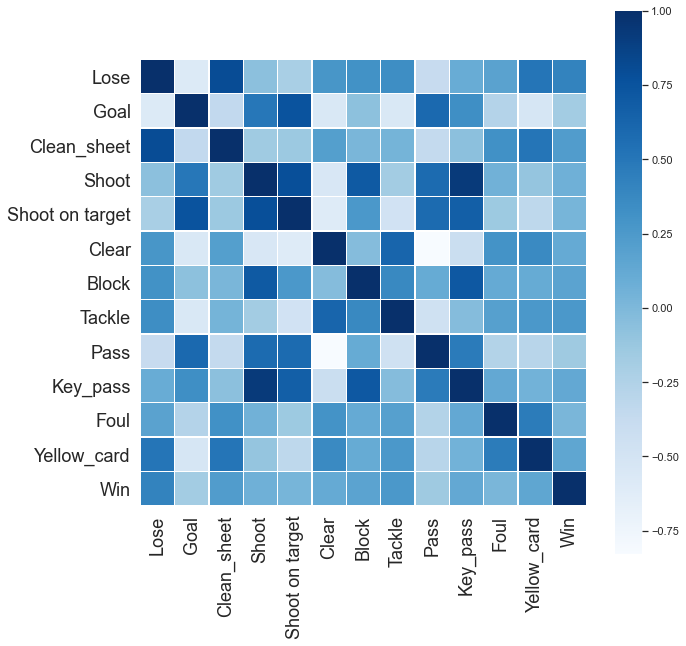

In [6]:
#绘制热力图，查看各特征相关性
train_matrix = euro_cup_normal.iloc[:,1:14].corr()
sns.set()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_matrix, annot=False, square=True, cmap="Blues",
linewidths=.5, vmax=1, ax=ax)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [166]:
#构造特征集x标签集y，并提取需要比较的数据
x=euro_cup_normal
y=euro_cup_data['results']
team1='西班牙'
team2='德国'
home_team_new=home_team_df.drop_duplicates()#去除重复项方便后面取数据
predict=pd.concat([home_team_new.loc[team1],home_team_new.loc[team2]])
predict_normal=(predict - predict.min()) / (predict.max() - predict.min())

In [169]:
#ANN神经网络
model_1 = MLPClassifier(max_iter=10000)
model_1.fit(x,y)
prob_model_1=model_1.predict_proba(np.atleast_2d(predict_normal))

print('%s vs' %(team1),'%s' % (team2))
print('赢球概率：%.3f' % (prob_model_1[0][0]))
print('平局概率：%.3f' % (prob_model_1[0][1]))
print('输球概率：%.3f' % (prob_model_1[0][2]))
print('交叉验证正确率：%.3f' % (np.mean(cross_val_score(model_1,x,y,cv=5))))#5折交叉验证

西班牙 vs 德国
赢球概率：0.803
平局概率：0.056
输球概率：0.140
交叉验证正确率：0.750
